# Анализ и выявление причины оттока клиентов банка

**Цель исследования:** выявить ключевые факторы, приведшие к массовому оттоку клиентов, а также определить портрет клиентов, сделать вывод.

**Задачи:** 
* Проведу предобработку данных
* Проведу исследовательский анализ
* Проведу проверку статистических гипотез
* Сформировать портрет отточных клиентов
* Напишу вывод о проделанной работе

## Описание данных

* **customer_id** - уникальный идентификатор клиента (формат RBANR_XXXXXX)
* **churn_flag** - флаг оттока (0 - клиент остался, 1 - клиент ушел)
* **gender** - пол клиента ("М" - мужчина, "Ж" - женщина)
* **age** - возраст клиента в года
* **city** - город проживания клиента
* **score** - кредитный рейтинг клиента (300-850)
* **balance** - текущий баланс на счете клиента (в рублях)
* **num_products** - количество банковских продуктов, которыми пользуется клиент
* **has_credit_card** - наличие у клиента кредитной карты (0 - нет, 1 - есть)
* **is_active_member** - активность клиента (0 - неактивен, 1 - активен)
* **tenure_months** - стаж клиента в банке в месяцах (время с открытия первого счета)
* **last_activity** - дата последней активности клиента (последняя транзакция или вход в систему)
* **churn_date** - дата оттока клиента (для ушедших), пусто, если клиент активен

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/Users/anastasiaklockova/Downloads/bank_customer_churn_dataset.csv')
df.head(5)

,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,last_activity,churn_date,churn_flag
0,770487,Ж,21,Казань,702,1.383352e+07,3,0,1,113,2020-02-15,NaN,0
1,216739,М,53,Москва,696,9.963152e+05,2,0,1,47,2020-02-17,NaN,0
2,126225,М,37,Ярославль,627,2.284864e+08,1,1,0,7,2020-01-12,2020-01-30,1
3,877572,Ж,49,СПб,498,3.855928e+06,1,0,1,4,2019-11-10,2019-11-28,1
4,388389,М,18,Екатеринбург,693,2.400842e+07,1,0,0,45,2020-02-24,NaN,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   gender            10000 non-null  object 
 2   age               10000 non-null  int64  
 3   city              10000 non-null  object 
 4   score             10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_products      10000 non-null  int64  
 7   has_credit_card   10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   tenure_months     10000 non-null  int64  
 10  last_activity     10000 non-null  object 
 11  churn_date        3022 non-null   object 
 12  churn_flag        10000 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 1015.8+ KB


#### Промежуточный вывод
* у столбца balance неверный тип данных
* видны пропуски в churn_date

## Предобработка данныx

1. ##### Проверка на работу с данными (все ли пользователи - это клиента банка)

In [4]:
#Проверим количество продуктов банка у клиента. Если количество продуктов равно 0, то соотвественно данный пользователь не является клиентом банка

df[df['num_products'] == 0]

,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,last_activity,churn_date,churn_flag


Видим, что нет ни одного клиента, который бы не являлся клиентом банка. Если бы количество продуктов равнялось 0, то соотвественно данный пользователь не является клиентом банка.

2. ##### Проверка на пропуски

In [5]:
missing = df.isnull().sum()
missing

customer_id            0
gender                 0
age                    0
city                   0
score                  0
balance                0
num_products           0
has_credit_card        0
is_active_member       0
tenure_months          0
last_activity          0
churn_date          6978
churn_flag             0
dtype: int64

Мы видим, что пропуски есть в столбце **churn_date**, которые ещё были видны при обзоре данных. Но стоит напомнить, что эти пропуски обозначают - клиент активен, т.е нет даты, когда пользователь перестал быть клиентом банка. Поэтому заполнение пропусков не требуется.

In [6]:
print(f"Всего пропусков в churn_date: {df['churn_date'].isnull().sum()} (это нормально для активных клиентов)")

Всего пропусков в churn_date: 6978 (это нормально для активных клиентов)


3. ##### Проверка на дубликаты

In [7]:
#Проведём проверку на явные дубликаты

full_duplicates = df.duplicated().sum()
print(f"Явных дубликатов:{full_duplicates}")

id_duplicates = df['customer_id'].duplicated().sum()
print(f"Дубликатов по customer_id:{id_duplicates}")

Явных дубликатов:0
Дубликатов по customer_id:0


In [8]:
#Проведет проверку неявных дубликатов

potential_duplicates = df.duplicated(subset=['gender', 'age', 'city', 'score', 'balance'], keep=False).sum()
print(f"Неявных дубликатов: {potential_duplicates}")

Неявных дубликатов: 0


4. ##### Преобразуем тип данных и даты

In [9]:
#Преобразование типа данных и дат

df['balance'] = df['balance'].astype('int64')
df['churn_date'] = pd.to_datetime(df['churn_date'])
df['last_activity'] = pd.to_datetime(df['last_activity'])
df.head(5)

,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,last_activity,churn_date,churn_flag
0,770487,Ж,21,Казань,702,13833515,3,0,1,113,2020-02-15,NaT,0
1,216739,М,53,Москва,696,996315,2,0,1,47,2020-02-17,NaT,0
2,126225,М,37,Ярославль,627,228486417,1,1,0,7,2020-01-12,2020-01-30,1
3,877572,Ж,49,СПб,498,3855927,1,0,1,4,2019-11-10,2019-11-28,1
4,388389,М,18,Екатеринбург,693,24008420,1,0,0,45,2020-02-24,NaT,0


In [10]:
## Создание дополнительных временных признаков
df['churn_year'] = df['churn_date'].dt.year                  #показывает год ухода
df['last_activity_month'] = df['last_activity'].dt.month     #показывает месяц ухода
df.head(5)

,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,last_activity,churn_date,churn_flag,churn_year,last_activity_month
0,770487,Ж,21,Казань,702,13833515,3,0,1,113,2020-02-15,NaT,0,NaN,2
1,216739,М,53,Москва,696,996315,2,0,1,47,2020-02-17,NaT,0,NaN,2
2,126225,М,37,Ярославль,627,228486417,1,1,0,7,2020-01-12,2020-01-30,1,2020.0,1
3,877572,Ж,49,СПб,498,3855927,1,0,1,4,2019-11-10,2019-11-28,1,2019.0,11
4,388389,М,18,Екатеринбург,693,24008420,1,0,0,45,2020-02-24,NaT,0,NaN,2


5. ##### Кодирование данных

In [11]:
# Для проведения в дальнейшем исследовательского анализа и просмотра корреляции, необходимо текстовые значения закодировать

#Для начала закодируем города
unique_citys=df['city'].unique()
print(unique_citys)

df['city_code'] = df['city']
df = pd.get_dummies(df, columns = ['city_code'], dtype = int)
df = df.rename (
    columns = ({
        'city_code_Казань':'Казань', 
        'city_code_Москва':'Москва',
        'city_code_Ярославль':'Ярославль',
        'city_code_СПб':'СПб',
        'city_code_Екатеринбург':'Екатеринбург',
        'city_code_Нижний Новгород':'Нижний Новгород',
        'city_code_Тверь':'Тверь',
        'city_code_Рязань':'Рязань'}))
df.head(2)

['Казань' 'Москва' 'Ярославль' 'СПб' 'Екатеринбург' 'Нижний Новгород'
 'Тверь' 'Рязань']


,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,...,churn_year,last_activity_month,Екатеринбург,Казань,Москва,Нижний Новгород,Рязань,СПб,Тверь,Ярославль
0,770487,Ж,21,Казань,702,13833515,3,0,1,113,...,NaN,2,0,1,0,0,0,0,0,0
1,216739,М,53,Москва,696,996315,2,0,1,47,...,NaN,2,0,0,1,0,0,0,0,0


In [12]:
#Теперь закадируем гендер
df['gender_code']=df['gender']
df = pd.get_dummies (df, columns = ['gender_code'], dtype = int)
df = df = df.rename (
    columns = ({
        'gender_code_Ж':'Пол: Ж',
        'gender_code_М':'Пол: М'}))
df.head(2)

,customer_id,gender,age,city,score,balance,num_products,has_credit_card,is_active_member,tenure_months,...,Екатеринбург,Казань,Москва,Нижний Новгород,Рязань,СПб,Тверь,Ярославль,Пол: Ж,Пол: М
0,770487,Ж,21,Казань,702,13833515,3,0,1,113,...,0,1,0,0,0,0,0,0,1,0
1,216739,М,53,Москва,696,996315,2,0,1,47,...,0,0,1,0,0,0,0,0,0,1


## Исследовательский анализ

1. Построим корреляционную матрицу

**Коэффициенты корреляции (-1 до +1)**
* +1: полная прямая линейная зависимость
* -1: полная оратная линейная зависимость
* 0: отсутствие линейной зависимости
  
* 0.7 - 1.0: сильная прямая связь
* 0.3 - 0.7: умеренная связь
* 0.0 - 0.3: слабая связь

In [13]:
# Выбор числовых признаков для корреляции
numerical_features = [
    'age', 'score', 'balance', 'num_products','has_credit_card', 'is_active_member', 'tenure_months','churn_flag',
    'Казань','Москва','Ярославль','СПб','Екатеринбург','Нижний Новгород','Тверь','Рязань',
    'Пол: Ж','Пол: М'
]

In [14]:
# Создание корреляционной матрицы
correlation_matrix = df[numerical_features].corr()

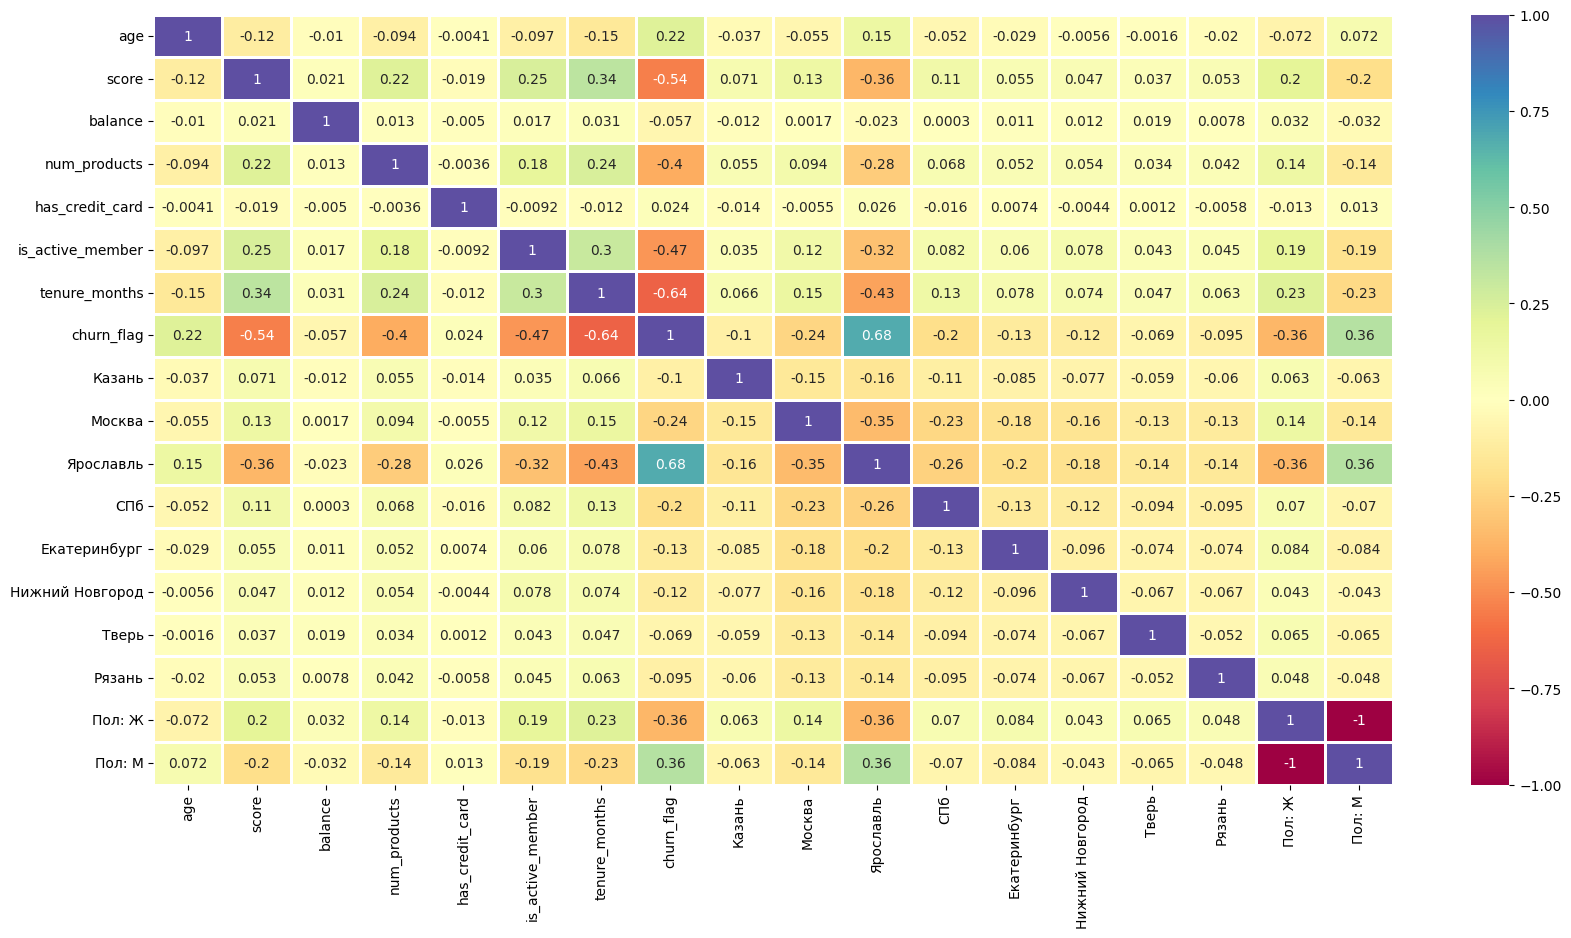

In [15]:
# Визуализация корреляционной матрицы
plt.figure(figsize=(20,10))
sns.heatmap (correlation_matrix,
             annot=True,           #подписывает значения внутри ячеек
             vmin=-1,              #цветовая шкала от -1 до 1
             vmax=1, 
             center= 0, 
             cmap= 'Spectral',     #цветовая схема
             linewidths=1)         #линии между ячейками
plt.show()

**Основные корреляции**
1. **Ярко выраженная отрицательная корреляция**
* -0,64: **churng_flag** и **tenure_months** (чем дольше клиент остается в банке, тем ниже вероятностьь его ухода)
* -0,54: **churng_flag** и **score** (более высокие баллы(score)связаны с меньшей вероятностью оттока(churn_flag))
* -0,47: **churng_flag** и **is_active_member** (если клиент является активным членом (is_active_member = 1), вероятность оттока (churn_flag) у него снижена)
* -0,43: **churng_flag** и **tenure_months** (чем больше месяцев клиент является клиентом банка (tenure_months), тем меньше вероятность его ухода (churn_flag))
* -0,4: **churng_flag** и **num_products** (клиенты с большим числом продуктов меньше склонны уходить)
* -0,36: **churng_flag** и **Пол: Ж** (женщины в данном наборе данных менее склонны к оттоку)

2. **Ярко выраженная положительная корреляция**
* 0,68: **churng_flag** и **Ярославль** (это может указывать, что жители Ярославля чаще уходят, чем из других городов)
* 0,36: **churng_flag** и **Пол: М** (указывает на то, что мужчины склонны к оттоку больше, чем женщины)
* 0,36: **Ярославль** и **Пол: М** (указывает на то, что мужчины склонны к оттоку из Ярославля)
* 0,34: **score** и **tenure_months** (чем выше баллы клиента (score), тем, как правило, дольше он остается клиентом банка (tenure_months))
* 0,25: **score** и **is_active_member** (более высокие баллы связаны с большей активностью клиента)
* 0,24: **num_products** и **tenure_months** (чем дольше клиент обслуживается, тем больше у него продуктов в банке)
* 0,22: **num_products** и **score** (клиенты с большим числом продуктов обычно имеют более высокий скоринговый балл)


**Промежуточный вывод:** большинство отточных клиентов это мужчины из Ярославля исходя из корреляционного анализа.

2. Выдвену гипотезы

#### Гипотеза №1: отток приходится преимущественно на мужчин


In [16]:
#Проверим сколько ушло мужчин и женщин
gender_stats = df.groupby('gender')['churn_flag'].agg(['count', 'sum', 'mean']).round(4)
gender_stats.columns = ['Всего', 'Ушли', 'Доля_оттока']

print("Статистика по полу:")
print(gender_stats)

Статистика по полу:
        Всего  Ушли  Доля_оттока
gender                          
Ж        4008   392       0.0978
М        5992  2630       0.4389


**Вывод по гипотезе №1:** отток действительно приходится преимущественно на мужчин

#### Гипотеза №2: отток приходится на Ярославль

In [17]:
#Проверим из какого города больше всего оттока
city_stats = df.groupby('city')['churn_flag'].agg(['count', 'sum', 'mean']).round(4)
city_stats.columns = ['Всего', 'Ушли', 'Доля_оттока']
city_stats = city_stats.sort_values('Доля_оттока', ascending=False)

print("Статистика по городам:")
print(city_stats)

Статистика по городам:
                 Всего  Ушли  Доля_оттока
city                                     
Ярославль         2775  2231       0.8040
Тверь              492    80       0.1626
Казань             639    80       0.1252
Екатеринбург       954   119       0.1247
Нижний Новгород    799    95       0.1189
Рязань             496    55       0.1109
Москва            2375   245       0.1032
СПб               1470   117       0.0796


**Вывод по гипотезе №2:** отток действительно приходится преимущественно на Ярославль

**Исходя из этих гипотез найдем долю этой группы от общего потока**

In [18]:
# 1. Общее число ушедших
total_churn = df['churn_flag'].sum()

# 2. Ушедшие мужчины из Ярославля
mask = (df['gender']=='М') & (df['city']=='Ярославль')
men_yar_churn = df[mask]['churn_flag'].sum()

# 3. Доля этой группы
share = men_yar_churn / total_churn

print(f"Всего ушло: {total_churn}")
print(f"Мужчин из Ярославля ушло: {men_yar_churn} ({share:.1%} от всех ушедших)")

if share > 0.5:
    print("Большинство ушедших — мужчины из Ярославля")
else:
    print("Большинство ушедших — другая группа")

Всего ушло: 3022
Мужчин из Ярославля ушло: 2179 (72.1% от всех ушедших)
Большинство ушедших — мужчины из Ярославля


### Вывод: 72,1% отточных клиентов составляют мужчины из Ярославля

3. Определим итоговый портрет отточных клиентов по следующим критериям:
* Пол
* Город
* Год ухода

1. **Пол:** мужской (определили в гипотезе №1)
2. **Город:** Ярославль (определили в гипотезе №2)
3. **Год ухода:**

In [19]:
# Подсчет оттока по годам
mask = (
    (df['gender'] == 'М') &
    (df['city'] == 'Ярославль') &
    (df['churn_flag'] == 1)
)
yaroslavl_men = df[mask].copy()
yearly_counts = yaroslavl_men['churn_year'].value_counts().sort_index()

print("Отток мужчин из Ярославля по годам:")
print(yearly_counts)

# Определение года с максимальным оттоком
peak_year = yearly_counts.idxmax()
peak_count = yearly_counts.max()


Отток мужчин из Ярославля по годам:
churn_year
2019.0      26
2020.0    2153
Name: count, dtype: int64


### Вывод: в 2020 году больше всего отточных клиентов, а именно мужчин из Ярославля

### Итоговый портрет отточных клиентов
1. **Пол:** мужской (определили в гипотезе №1)
2. **Город:** Ярославль (определили в гипотезе №2)
3. **Год ухода:** 2020 год

Исходя из протрета отточных клиентов, можно сделать вывод, что отток пришёлся на 2020 год, в момент начала пандемии COVID-19,потеря дохода и экономическая неопределённость спровоцировали массовое снятие вкладов, закрытие счетов и т.д

### Вывод по проделанной работе
В ходе исследования при помощи тепловой карты корреляции были выявлены факторы влияющие на отток клиентов

**Факторы, которые влияют на отток клиентов:**
1. Мужчины склонны к оттоку больше, чем женщины
2. Мужчины склонны к оттоку из Ярославля

**Были выведены две гипотезе**